In [166]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utilities import train_test_val_split, rmse, load_matlab_data
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [167]:
matlab_data = loadmat("data/hwk8data.mat")
print(matlab_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'data', 'test1', 'test2'])


In [168]:
data = matlab_data['data']
test1 = matlab_data['test1']
test2 = matlab_data['test2']

In [169]:
print(data.shape)

(450, 21)


Briefly describe PCA and how it is used for anomaly detection. Describe the use of Q- and T2-statistics for detecting anomalies. Give the equations for calculating the Q- and T2-statistics.

In [170]:
def t2(data, pca):
    """Calculate the T^2 score for a data sample
    """
    l = np.diag(pca.explained_variance_)
    t = pca.transform(data)
    return np.array([tt @ l @ tt.T for tt in t])

In [171]:
def q(data, pca):
    """Calculate Q-score for a data sample
    """
    # Get dimensionality of the data
    i = data.shape[1]
    
    pp = pca.components_.T @ pca.components_
    
    return np.array([x @ (np.eye(i) - pp) @ x.T for x in data])

Develop a PCA model of the normal operating data contained in data.

In [172]:
scale = StandardScaler().fit(data)

In [173]:
data_s = scale.transform(data)

In [174]:
pca = PCA().fit(data_s)

In [175]:
test1_s = scale.transform(test1)
test2_s = scale.transform(test2)

Determine on your own how many PCs should be included in the model.

Calculate the number of components required to explain 95% of the variance

In [176]:
np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)

(array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),)

Text(0, 0.5, 'Fraction of variance explained')

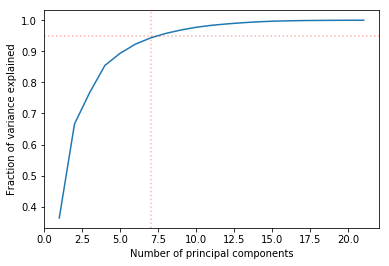

In [177]:
plt.plot(range(1, pca.explained_variance_.shape[0]+1), np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, color='r', linestyle=':', alpha=0.3)
plt.axvline(x=7, color='r', linestyle=':', alpha=0.3)
plt.xlabel("Number of principal components")
plt.ylabel("Fraction of variance explained")

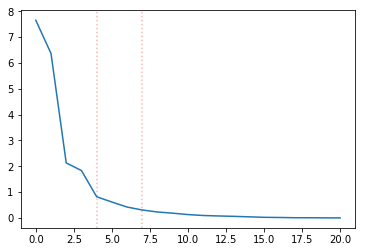

In [178]:
plt.plot(pca.explained_variance_)
plt.axvline(x=4, color='r', linestyle=':', alpha=0.3)
plt.axvline(x=7, color='r', linestyle=':', alpha=0.3)

In [179]:
np.sum(pca.explained_variance_ratio_[:5])

0.893705287056583

Calculate the norm of the residuals as a percentage of the norm of the scaled training data

In [180]:
e = []
for i in range(1, data.shape[1]):
    pc = PCA(n_components=i).fit(data_s)
    p = pc.inverse_transform(pc.transform(data_s))
    res = la.norm(data_s - p) / la.norm(data_s)
    e.append(np.mean(res))

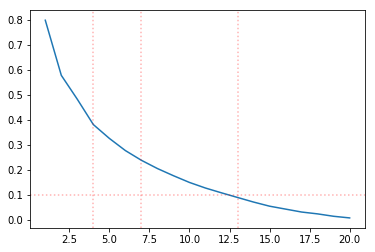

In [181]:
plt.plot(range(1, data.shape[1]), e)
plt.axhline(y=0.1, color='r', linestyle=':', alpha=0.3)
plt.axvline(x=13, color='r', linestyle=':', alpha=0.3)
plt.axvline(x=4, color='r', linestyle=':', alpha=0.3)
plt.axvline(x=7, color='r', linestyle=':', alpha=0.3)

No clear elbow in this plot. 8 principal components gives ~25% variance from the model.

Determine which components carry more than $\epsilon$ variance

In [182]:
epsilon = 0.005

In [183]:
np.where(pca.explained_variance_ratio_ > epsilon)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),)

Look at $T^2$ and Q values to select threshold values

In [184]:
def plot_q_and_t2(data_s, n_components, t2_thresh=None, q_thresh=None):
    pc = PCA(n_components=n_components)
    pc.fit(data_s)
    qvals = q(data_s, pc)
    t2vals = t2(data_s, pc)
    f, axs= plt.subplots(1, 2)
    axs[0].plot(t2vals, '.')
    axs[0].set_title(r"$T^2$")
    if t2_thresh is not None:
        axs[0].axhline(y=t2_thresh, color='r',
                    alpha=0.3, linestyle=':')
    axs[1].plot(qvals, '.')
    axs[1].set_title(r"Q")
    if q_thresh is not None:
        axs[1].axhline(y=q_thresh, color='r',
                    alpha=0.3, linestyle=':')
    plt.suptitle(f"{n_components} PCs")
    plt.show()

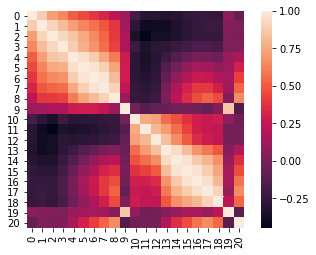

In [185]:
sns.heatmap(np.corrcoef(data_s, rowvar=False), square=True)

From the correlation heat map it appears that the dimensionality of these data are at least 4

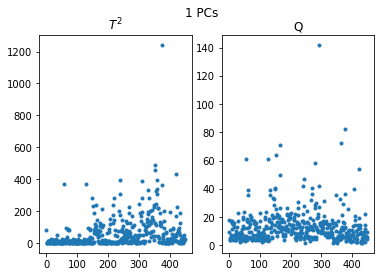

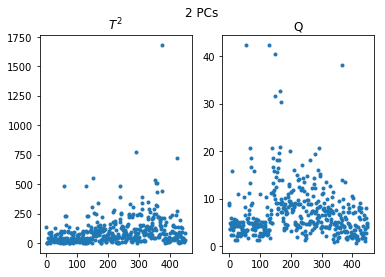

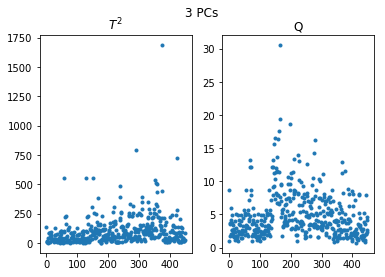

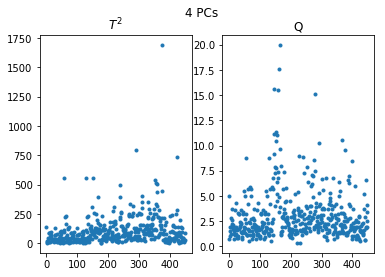

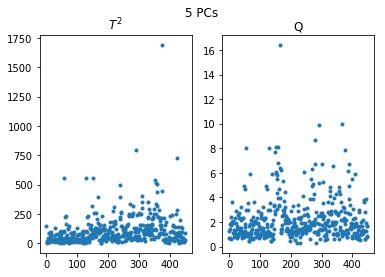

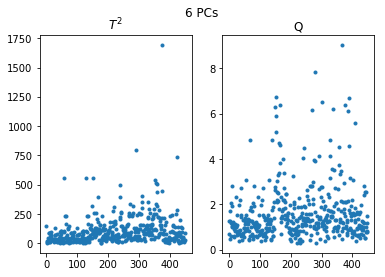

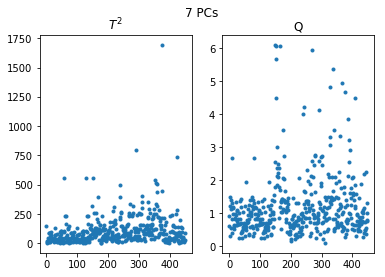

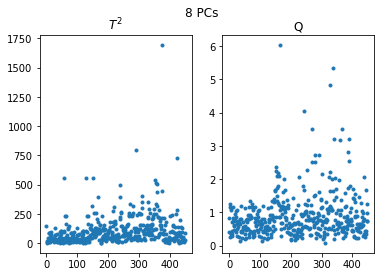

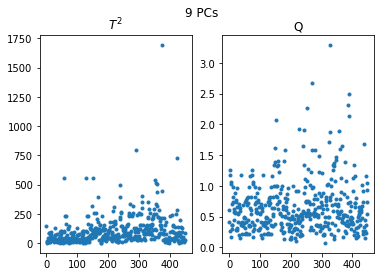

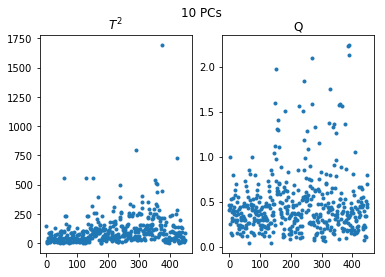

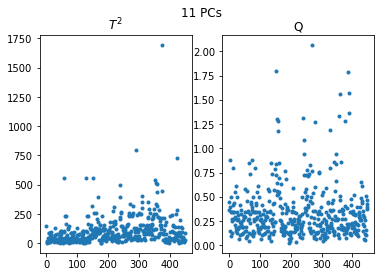

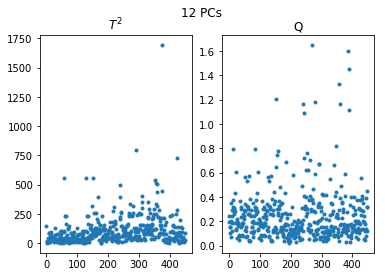

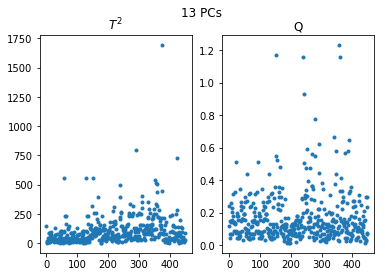

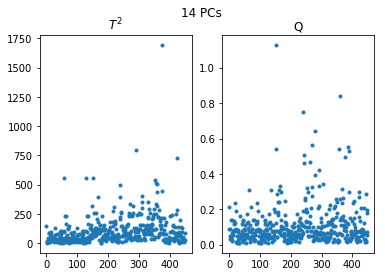

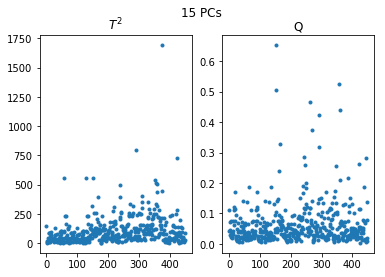

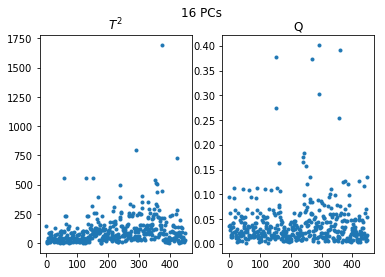

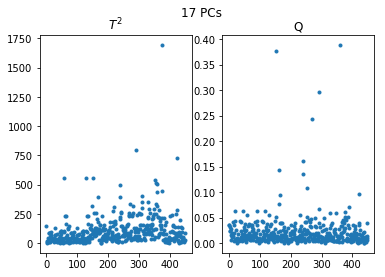

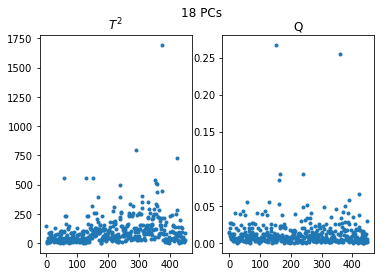

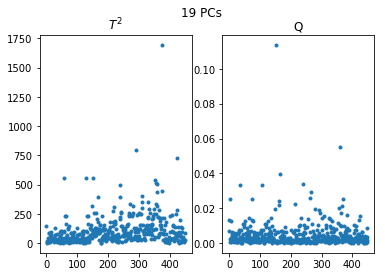

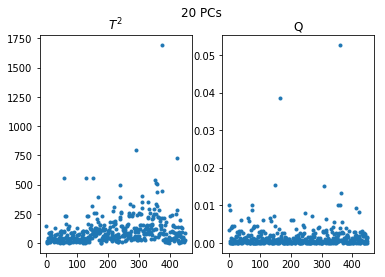

In [186]:
for _ in range(1, data_s.shape[1]):
    plot_q_and_t2(data_s, _)

$T^2$ settles down after 2 PC's. $Q$ (as expected) continues to lower as number of PC's increases (since more of the data is captured in the model). Based on the plots above I have selected 8 PC's

In [187]:
pca = PCA(n_components=2)
pca.fit(data_s)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Now set the $T^2$ and $Q$ thresholds at the 95% quantile

In [188]:
t2_data = t2(data_s, pca)

In [189]:
t2_thresh = np.quantile(t2_data, 0.95)

In [190]:
q_data = q(data_s, pca)

In [191]:
q_thresh = np.quantile(q_data, 0.95)

In [192]:
t2_thresh

289.34112550644437

In [193]:
q_thresh

16.299470915341658

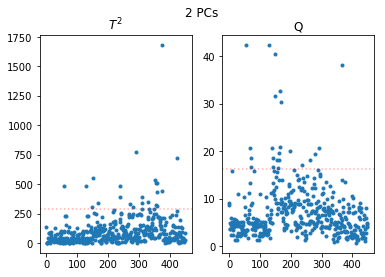

In [216]:
plot_q_and_t2(data_s, 2, t2_thresh=np.quantile(t2_data, 0.95),
              q_thresh=np.quantile(q_data, 0.95))

Project the data in `test1` and `test2` into the PC space that you found in step 2. Evaluate the $T^2$- and $Q$-statistics to identify which, if any, observations are anomalous.

In [195]:
t2_1 = t2(test1_s, pca)

In [196]:
q_1 = q(test1_s, pca)

In [197]:
t2_2 = t2(test2_s, pca)

In [198]:
q_2 = q(test2_s, pca)

In [199]:
hue_t1 = np.zeros_like(t2_1)
hue_t1[np.argwhere(t2_1 > t2_thresh)] = 1

In [200]:
hue_t2 = np.zeros_like(t2_2)
hue_t2[np.argwhere(t2_2 > t2_thresh)] = 1

In [201]:
hue_q1 = np.zeros_like(q_1)
hue_q1[np.argwhere(q_1 > q_thresh)] = 1

In [202]:
hue_q2 = np.zeros_like(q_2)
hue_q2[np.argwhere(q_2 > q_thresh)] = 1

Text(0, 0.5, 'PC2 Score')

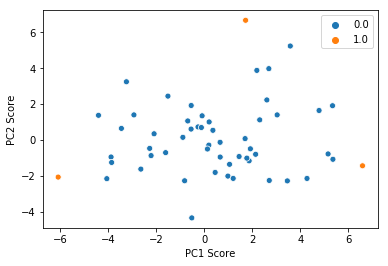

In [218]:
sns.scatterplot(pca.transform(test1_s)[:,0],
                pca.transform(test1_s)[:,1],
                hue=hue_t1)
plt.xlabel("PC1 Score")
plt.ylabel("PC2 Score")

Text(0, 0.5, 'PC2 Score')

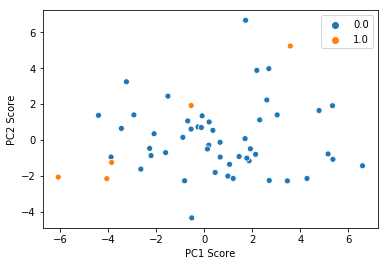

In [220]:
sns.scatterplot(pca.transform(test1_s)[:,0],
                pca.transform(test1_s)[:,1],
                hue=hue_q1)
plt.xlabel("PC1 Score")
plt.ylabel("PC2 Score")

Text(0, 0.5, 'PC2 Score')

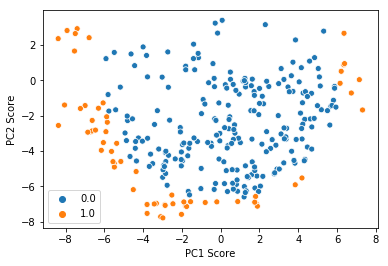

In [221]:
sns.scatterplot(pca.transform(test2_s)[:,0],
                pca.transform(test2_s)[:,1],
                hue=hue_t2)
plt.xlabel("PC1 Score")
plt.ylabel("PC2 Score")

Text(0, 0.5, 'PC2 Score')

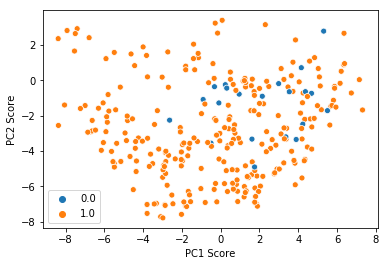

In [222]:
sns.scatterplot(pca.transform(test2_s)[:,0],
                pca.transform(test2_s)[:,1],
                hue=hue_q2)
plt.xlabel("PC1 Score")
plt.ylabel("PC2 Score")

In [208]:
def new_plot_q_and_t2(data_s, pc=pca, t2_thresh=None, q_thresh=None):
    qvals = q(data_s, pc)
    t2vals = t2(data_s, pc)
    f, axs= plt.subplots(1, 2)
    axs[0].plot(t2vals, '.')
    axs[0].set_title(r"$T^2$")
    if t2_thresh is not None:
        axs[0].axhline(y=t2_thresh, color='r',
                    alpha=0.3, linestyle=':')
    axs[1].plot(qvals, '.')
    axs[1].set_title(r"Q")
    if q_thresh is not None:
        axs[1].axhline(y=q_thresh, color='r',
                    alpha=0.3, linestyle=':')
    plt.show()

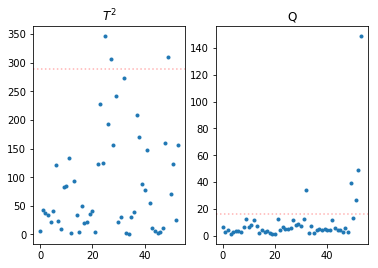

In [209]:
new_plot_q_and_t2(test1_s, t2_thresh=t2_thresh,
              q_thresh=q_thresh)

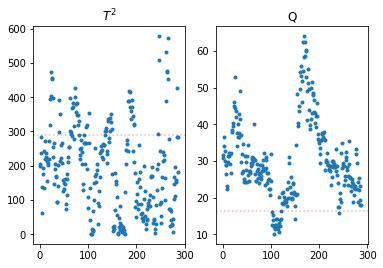

In [210]:
new_plot_q_and_t2(test2_s, t2_thresh=t2_thresh,
              q_thresh=q_thresh)

From these scores it appears that the data in `test1` is consistent with the training data, while the data in `test2` are anomalous.

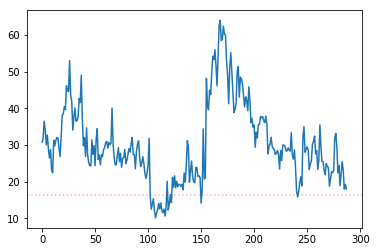

In [211]:
plt.plot(q_2)
plt.axhline(y=q_thresh, color='r', linestyle=':', alpha=0.3)

In [224]:
np.argwhere(q_1 > q_thresh)

array([[32],
       [49],
       [51],
       [52],
       [53]])

In [225]:
np.argwhere(t2_1 > t2_thresh)

array([[25],
       [27],
       [49]])

In [230]:
data_s[0] @ pca.components_[0].T * np.diag(pca.explained_variance_) @ pca.components_[0] * data_s[0]

ValueError: shapes (2,2) and (21,) not aligned: 2 (dim 1) != 21 (dim 0)

In [ ]:
def t2_cont(data_s, pca, index):
    data_s[index] * 